In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Union

import candle
import candle.functions as F
import experiments.trainingutils as tutils

## (1) Load data

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

X = digits.images[:, None]  # Add channel dimension

X_train, X_test, y_train, y_test = train_test_split(  # Split data into 50% train and 50% test subsets
    X, digits.target, test_size=0.5, shuffle=False
)

# Standardize data

train_mean = X_train.mean()
train_std = X_train.std()
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

num_features = X_train.shape[1]
num_classes = len(set(y_train.data))

In [4]:
X_train = candle.Tensor(X_train)
y_train = candle.Tensor(y_train)
X_test = candle.Tensor(X_test)
y_test = candle.Tensor(y_test)

X_train.shape, y_train.shape

((898, 1, 8, 8), (898,))

## (2) Define Training Configuration

In [5]:
class Config:
    # General configs
    
    ITERATIONS = 2200
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-1
    
    EVAL_ITERS = 1
    EVAL_BATCH_SIZE = 64 
    DASHBOARD_REFRESH_ITERS = 100
    
    # LR scheduler configs
    
    STEPLR_STEP_SIZE = 500
    STEPLR_GAMMA = 0.2
    WARMUP_STEPS = 200
    
    # Model-specific configs

    RESNET_BLOCKS = [
        # (in_channels, out_channels, stride)
        (8, 8, 1),
        (8, 8, 1),

        (8, 16, 1),
        (16, 16, 1),
    ]


config = Config()

## (3) Define Model

In [6]:
"""Residual Network.

References:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.
    Deep Residual Learning for Image Recognition. arXiv:1512.03385, 2015,
    
"""

class ResNet(candle.Module):
    
    def __init__(self,
                 num_classes: int,
                 in_channels: int,
                 resnet_blocks: List[Tuple[int, int, int]]):
        super().__init__()
        self.num_classes = num_classes
        
        self.conv = candle.Conv2d(in_channels, resnet_blocks[0][0], kernel_size=3, padding=1, stride=1)
        self.batch_norm = candle.BatchNorm(axis=(0, 2, 3))
#         self.max_pool = candle.MaxPool2d(kernel_size=2)  # Remove MaxPool since MNIST is only 8x8
        
        self.residual_blocks = candle.ParameterList([
            ResNetBlock(in_channels, out_channels, stride)
            for (in_channels, out_channels, stride) in resnet_blocks
        ])
        
        self.linear = candle.Linear(resnet_blocks[-1][1], num_classes)
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        
#         x = self.max_pool(x)
        
        for residual_block in self.residual_blocks:
            x = residual_block(x)
            x = F.relu(x)
            
        x = x.mean(axis=(2, 3))
        x = self.linear(x)
        
        return x
    
    
class ResNetBlock(candle.Module):
    
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 stride: int = 1):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        self.conv1 = candle.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = candle.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        self.batch_norm1 = candle.BatchNorm(axis=(0, 2, 3))
        self.batch_norm2 = candle.BatchNorm(axis=(0, 2, 3))
        
        if in_channels != out_channels:
            self.res_conv = candle.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.res_conv = None
            
            
    def forward(self, x):
        x_conv = self.conv1(x)
        x_conv = self.batch_norm1(x_conv)
        x_conv = F.relu(x_conv)
        
        x_conv = self.conv2(x_conv)
        x_conv = self.batch_norm2(x_conv)
        
        if self.res_conv is not None:
            x = self.res_conv(x)
            
        x_conv = x + x_conv
        
        return x_conv

In [7]:
model = ResNet(num_classes=num_classes,
               in_channels=X_train.shape[1],
               resnet_blocks=config.RESNET_BLOCKS)

optimizer = candle.optimizer.AdamW(model.parameters(),
                                   learning_rate=config.LEARNING_RATE,
                                   weight_decay=config.WEIGHT_DECAY)

scheduler = candle.scheduler.WarmupWrapper(candle.scheduler.StepLR(optimizer,
                                                                   step_size=config.STEPLR_STEP_SIZE,
                                                                   gamma=config.STEPLR_GAMMA),
                                           warmup_steps=config.WARMUP_STEPS)

_ = model(X_train[:1])  # to initialize params that have deferred init

model.summary(input_shape=(64, 1, 8, 8))

,Layer Type,# Parameters,Output Shape
conv,Conv2d,80,"(64, 8, 8, 8)"
batch_norm,BatchNorm,16,"(64, 8, 8, 8)"
residual_blocks.0,ResNetBlock,1200,"(64, 8, 8, 8)"
residual_blocks.1,ResNetBlock,1200,"(64, 8, 8, 8)"
residual_blocks.2,ResNetBlock,3696,"(64, 16, 8, 8)"
residual_blocks.3,ResNetBlock,4704,"(64, 16, 8, 8)"
linear,Linear,170,"(64, 10)"
Total,,11066,


## (4) Check Activations and Gradients at Initialization

In [8]:
# Register forward hooks to facilitate activation logging

layer_activations = {}
def store_activations(layer_name):
    def hook_fn(module, input, output):
        layer_activations[layer_name] = output
    
    return hook_fn


def get_activations():
    act_by_layer = {layer_name: layer_activations[layer_name].data.flatten() for layer_name in layer_activations}
    activations = np.concatenate(list(act_by_layer.values()))
    act_norm_by_layer = {layer_name: np.linalg.norm(act) for (layer_name, act) in act_by_layer.items()}
    act_rmsnorm_by_layer = {name: np.sqrt(np.mean(np.square(act_by_layer[name]))) for name in act_by_layer}
    
    return (activations, act_by_layer, act_norm_by_layer, act_rmsnorm_by_layer)


params_to_track = (
    [f'residual_blocks.{i}.conv1.kernel' for i in range(len(model.residual_blocks))]
    + [f'residual_blocks.{i}.conv2.kernel' for i in range(len(model.residual_blocks))]
)

for (i, layer) in enumerate(model.residual_blocks):
    layer.register_forward_hook(store_activations(f'residual_blocks.{i}'))    

In [9]:
X_batch = X_train[:256]
y_batch = y_train[:256]

output = model(X_batch)
loss = F.cross_entropy_loss(output, y_batch)
loss.backward()

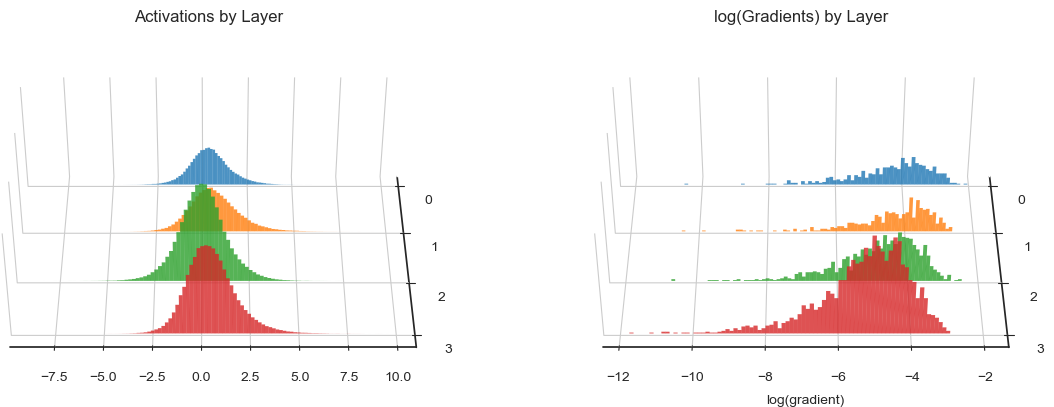

In [10]:
writer = candle.Dashboard()
writer.change_settings('xlim', (-12, np.inf), chart_label='log(Gradients) by Layer')
writer.change_settings('hist_xlabel', 'log(gradient)', chart_label='log(Gradients) by Layer')

for layer_name in layer_activations:
    writer.add_histogram('Activations by Layer', layer_activations[layer_name].data.flatten())

for layer in model.residual_blocks:
    gradients = layer.conv1.kernel.grad.flatten()
    writer.add_histogram('log(Gradients) by Layer', np.log(np.abs(gradients) + 1e-10))

writer.plot()

## (5) Train Model

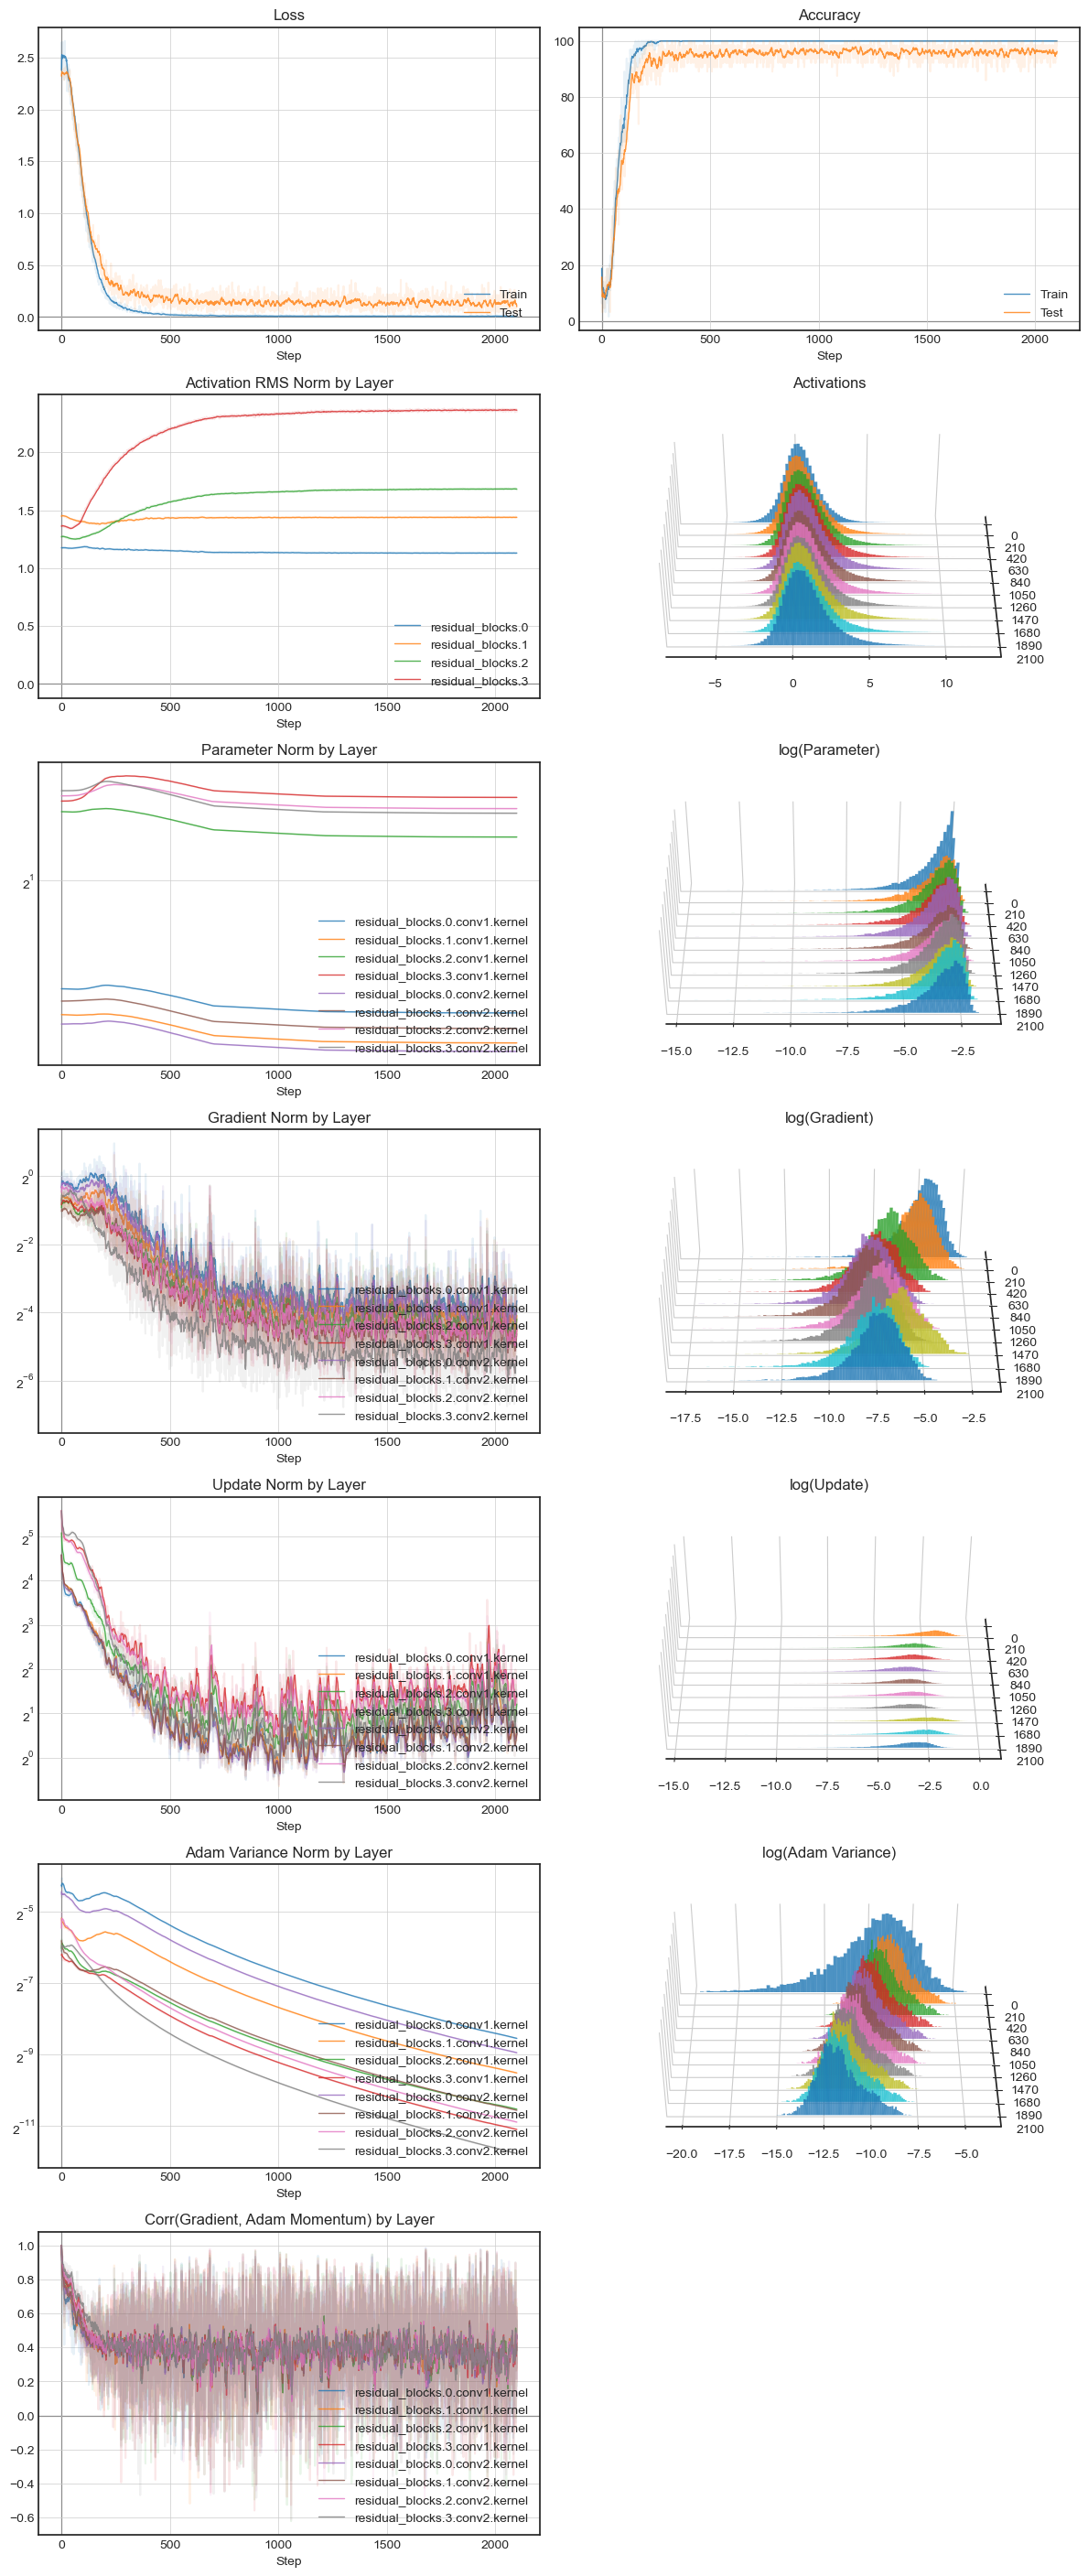

In [11]:
writer = candle.Dashboard()
for label in ['Parameter', 'Gradient', 'Update', 'Adam Variance']:
    writer.change_settings('xlim', (-20, np.inf), chart_label=f'log({label})')
    writer.change_settings('yscale', 'log', chart_label=f'{label} Norm by Layer')

data_loader = candle.DataLoader(X_train, y_train, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
data_iterator = iter(data_loader)

for iteration in range(config.ITERATIONS):
    
    model.train()

    try:
        (X_batch, y_batch) = next(data_iterator)
    except StopIteration:
        data_iterator = iter(data_loader)
        (X_batch, y_batch) = next(data_iterator)

    output = model(X_batch)
    loss = F.cross_entropy_loss(output, y_batch)
    loss.backward()
    
    optimizer.step()
    scheduler.step()
    
    # -----------------
    # Visualize metrics
    # -----------------

    model.eval()

    (activations, act_by_layer, act_norm_by_layer, act_rmsnorm_by_layer) = get_activations()
    (parameters, param_by_layer, param_norm_by_layer) = tutils.get_parameters(params_to_track, model)
    (gradients, grad_by_layer, grad_norm_by_layer) = tutils.get_gradients(params_to_track, model)
    (updates, upd_by_layer, upd_norm_by_layer) = tutils.get_adam_updates(params_to_track, optimizer)
    (adam_var, adam_var_by_layer, adam_var_norm_by_layer) = tutils.get_adam_var(params_to_track, optimizer)
    (adam_mom, adam_mom_by_layer, adam_mom_norm_by_layer) = tutils.get_adam_mom(params_to_track, optimizer)
    
    corr_grad_mom_by_layer = {
        name: np.corrcoef(grad_by_layer[name].flatten(),
                          adam_mom_by_layer[name].flatten())[0, 1]
        for name in params_to_track
    }
    
    (train_loss, train_acc) = tutils.get_loss_and_accuracy(model, X_batch, y_batch, output.data)
    writer.add_scalars('Loss', {'Train': train_loss})
    writer.add_scalars('Accuracy', {'Train': train_acc})

    if iteration % config.EVAL_ITERS == 0:
        test_batch = tutils.get_random_batch(X_test, y_test, batch_size=config.EVAL_BATCH_SIZE)
        (test_loss, test_acc) = tutils.get_loss_and_accuracy(model, *test_batch)
        writer.add_scalars('Loss', {'Test': test_loss}, iteration)
        writer.add_scalars('Accuracy', {'Test': test_acc}, iteration)
        
    writer.add_scalars('Activation RMS Norm by Layer', act_rmsnorm_by_layer)
    writer.add_histogram('Activations', activations)

    writer.add_scalars('Parameter Norm by Layer', param_norm_by_layer)
    writer.add_histogram('log(Parameter)', np.log(np.abs(parameters) + 1e-10))
    
    writer.add_scalars('Gradient Norm by Layer', grad_norm_by_layer)
    writer.add_histogram('log(Gradient)', np.log(np.abs(gradients) + 1e-10))

    writer.add_scalars('Update Norm by Layer', upd_norm_by_layer)
    writer.add_histogram('log(Update)', np.log(np.abs(updates) + 1e-10))

    writer.add_scalars('Adam Variance Norm by Layer', adam_var_norm_by_layer)
    writer.add_histogram('log(Adam Variance)', np.log(np.abs(adam_var) + 1e-10))

    writer.add_scalars('Corr(Gradient, Adam Momentum) by Layer', corr_grad_mom_by_layer)
    
    if iteration % config.DASHBOARD_REFRESH_ITERS == 0:
        writer.plot(clear_output=True)

## (6) Visualize Predictions

Final Test Accuracy: 96.22%


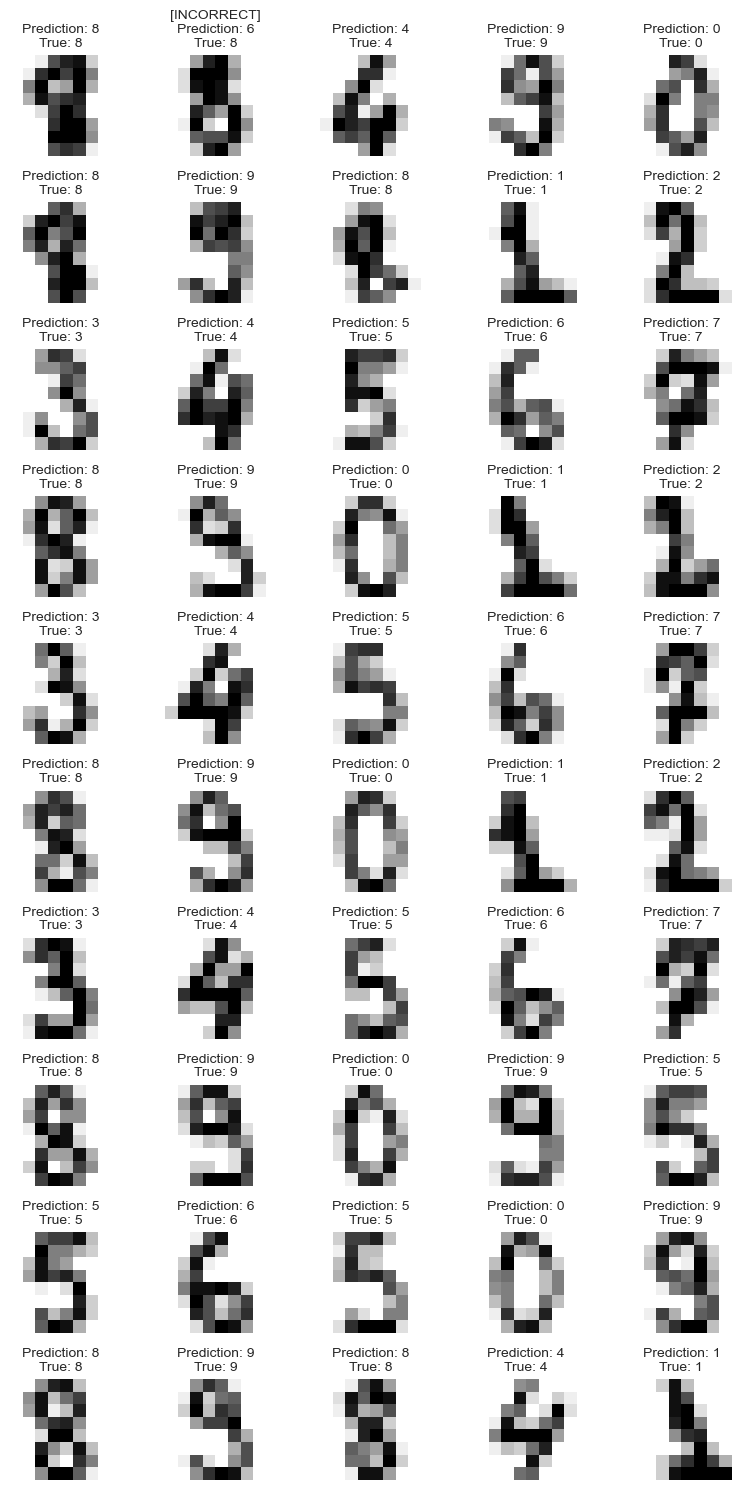

In [12]:
predictions = tutils.get_predictions(model, X_test)
(test_loss, test_acc) = tutils.get_loss_and_accuracy(model, X_test, y_test)
print(f'Final Test Accuracy: {test_acc:.2f}%')

(fig, axes) = plt.subplots(nrows=10, ncols=5, figsize=(8, 3*5))
axes = axes.flatten()
for (ax, image, prediction, label) in zip(axes, X_test.data, predictions, y_test.data):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    wrong_label = '[INCORRECT]\n' if prediction != label else ''
    ax.set_title(f'{wrong_label}Prediction: {prediction}\nTrue: {label}', fontsize=10)
    
plt.tight_layout()
plt.show()

## (7) Visualize First Kernel

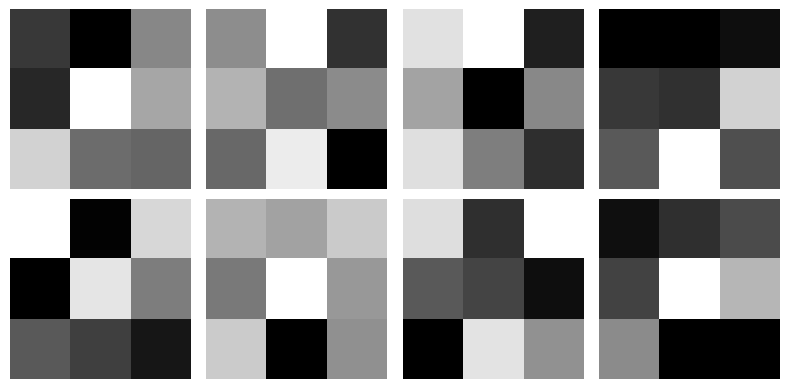

In [13]:
(fig, axes) = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
axes = axes.flatten()

in_channels = model.conv.kernel.shape[0]
out_channels = model.conv.kernel.shape[1]

in_channel_i = 0
for (ax, out_channel_i) in zip(axes, range(out_channels)):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(model.conv.kernel[in_channel_i, out_channel_i].data, cmap=plt.cm.gray_r, interpolation='nearest')
    
plt.tight_layout()
plt.show()